In [322]:
%load_ext autoreload
%autoreload 2

import asyncio, copy, cv2, dlib, os, socket, sys, time
from functools import partial
from multiprocessing import Pool, Process
from pathlib import Path
from tqdm import tqdm

import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import shap
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))
from libs import nn, resnet, sim
#from cfgs.fedargs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [323]:
# Device settings
use_cuda = torch.cuda.is_available()
torch.manual_seed(10)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [324]:
def shap_plot(explain, img, size):
    #shap_image = g_img.unsqueeze(0)
    shap_values = explain.shap_values(img.unsqueeze(0))
    
    shap_tensor = torch.tensor(shap_values)
    shap_lists = []
    for i in range(2):
        lsum = 0
        lst = shap_tensor[i].squeeze(0).squeeze(0).view(size).tolist()
        shap_lists.append(lst)
        for l in lst:
            if l > 0:
                lsum += abs(l)
        print ('shap_sum', lsum)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(img.unsqueeze(0).numpy(), 1, -1), 1, 2)
    shap.image_plot(shap_numpy, -test_numpy, None, 20, 0.2, 0.2, None, False)
    #shap.image_plot(shap_values, -shap_image)
    return shap_values

<h1>Gender: ResNet</h1>

In [325]:
df = pd.read_csv('../../data/celeba/list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male', 'Smiling'])

df1 = df[df['Smiling'] == 1]

df1 = df1[['Male']]
print(len(df), len(df1))

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df1.loc[df1['Male'] == -1, 'Male'] = 0

df1.tail()

202599 97669


,Male
202592.jpg,0
202593.jpg,0
202596.jpg,1
202597.jpg,1
202598.jpg,0


In [326]:
df2 = pd.read_csv('../../data/celeba/list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.tail()

,Partition
Filename,
202595.jpg,2
202596.jpg,2
202597.jpg,2
202598.jpg,2
202599.jpg,2


In [327]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.tail()

,Male,Partition
202592.jpg,0,2
202593.jpg,0,2
202596.jpg,1,2
202597.jpg,1,2
202598.jpg,0,2


In [328]:
df3.to_csv('celeba-gender-partitions.csv')
df4 = pd.read_csv('celeba-gender-partitions.csv', index_col=0)
df4.tail()

,Male,Partition
202592.jpg,0,2
202593.jpg,0,2
202596.jpg,1,2
202597.jpg,1,2
202598.jpg,0,2


In [329]:
df4.loc[df4['Partition'] == 0].to_csv('celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('celeba-gender-test.csv')

(218, 178, 3)


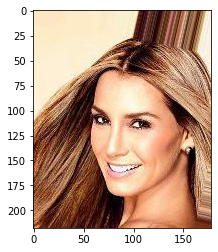

In [330]:
img = Image.open('../../data/celeba/img_align_celeba/000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

In [331]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [332]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally
BATCH_SIZE = 256

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='celeba-gender-train.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='celeba-gender-valid.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='celeba-gender-test.csv',
                             img_dir='../../data/celeba/img_align_celeba/',
                             transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [333]:
target_model = resnet.ResNet18(2)
#MS_FS
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MS30K_FS_30K)_3e_pth", map_location ='cpu'))
#MNS_FNS
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MNS_30K_FNS_30K)_pth", map_location ='cpu'))
#MNS_FS
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MNS_30K_FS_30K)_pth", map_location ='cpu'))
#MS_FNS
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MS_30K_FNS_30K)_pth", map_location ='cpu'))
#MS_30_MNS_10_FS_30_FNS_10
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MS_30K_MNS_10K_FS_30K_FNS_10K)_pth", map_location ='cpu'))
#MS_10_MNS_30_FS_10_FNS_30
target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MS_10K_MNS_30K_FS_10K_FNS_30K)_pth", map_location ='cpu'
target_model.eval()
print("Model Loaded")

SyntaxError: invalid syntax (1876807210.py, line 14)

<h1>SHAP Explain</h1>

In [ ]:
target_batch = next(iter(test_loader))
target_images, target_labels = target_batch
target_baseline = target_images
    
target_explain = shap.DeepExplainer(target_model, target_baseline)

In [ ]:
r_img = torch.tensor([[[0.0 for col in range(128)] for row in range(128)] for dim in range(3)])
#z_img = z_img.reshape(1,28,28)
r_img.shape
#plt.imshow(z_img.numpy().squeeze())

In [ ]:
_target_shap_values = shap_plot(target_explain, r_img, 49152)

In [ ]:
target_shap_values = torch.tensor(_target_shap_values)
target_shap_values.shape

<h1>MS_FS</h1>

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap_sum 3876.865536070255
shap_sum 3789.779555226123


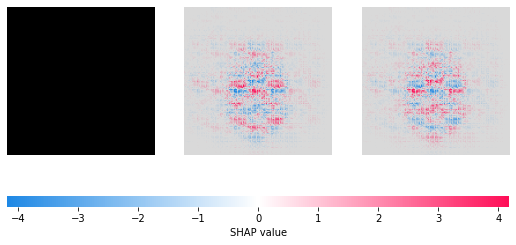

In [334]:
ms_fs_model = resnet.ResNet18(2)
ms_fs_model.load_state_dict(torch.load("../../out/models/PIA_result/SM(ms_5k_fs_5k)_3e.pth", map_location ='cpu'))
ms_fs_model.eval()
ms_fs_explain = shap.DeepExplainer(ms_fs_model, target_baseline)
ms_fs_shap_values = shap_plot(ms_fs_explain, r_img, 49152)

<h1>MNS_FNS</h1>

shap_sum 3354.110013224875
shap_sum 3815.472641650064


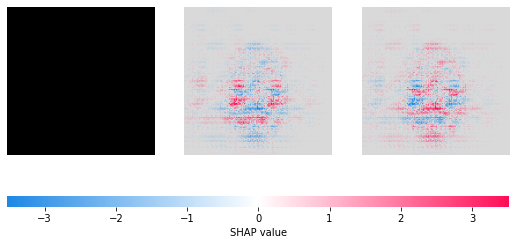

In [335]:
mns_fns_model = resnet.ResNet18(2)
mns_fns_model.load_state_dict(torch.load("../../out/models/PIA_result/SM(mns_5k_fns_5k)_3e.pth", map_location ='cpu'))
mns_fns_model.eval()
mns_fns_explain = shap.DeepExplainer(mns_fns_model, target_baseline)
mns_fns_shap_values = shap_plot(mns_fns_explain, r_img, 49152)

<h1>MS_FNS</h1>

shap_sum 3024.462873765431
shap_sum 3056.713001687298


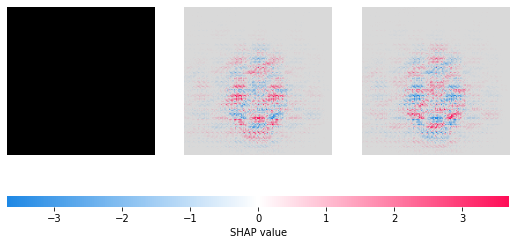

In [336]:
ms_fns_model = resnet.ResNet18(2)
ms_fns_model.load_state_dict(torch.load("../../out/models/PIA_result/SM(ms_5k_fns_5k)_3e.pth", map_location ='cpu'))
ms_fns_model.eval()
ms_fns_explain = shap.DeepExplainer(ms_fns_model, target_baseline)
ms_fns_shap_values = shap_plot(ms_fns_explain, r_img, 49152)

<h1>MNS_FS</h1>

shap_sum 4768.043721374981
shap_sum 4874.783271807207


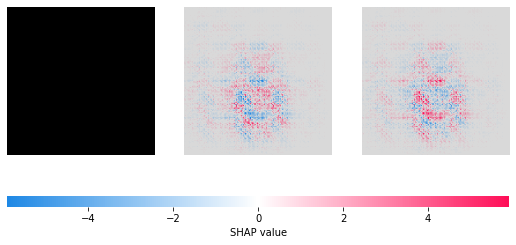

In [337]:
mns_fs_model = resnet.ResNet18(2)
mns_fs_model.load_state_dict(torch.load("../../out/models/PIA_result/SM(mns_5k_fs_5k)_3e.pth", map_location ='cpu'))
mns_fs_model.eval()
mns_fs_explain = shap.DeepExplainer(mns_fs_model, target_baseline)
mns_fs_shap_values = shap_plot(mns_fs_explain, r_img, 49152)

# MS_1K_MNS_4K_FS_1K_FNS_4k

shap_sum 4768.043721374981
shap_sum 4874.783271807207


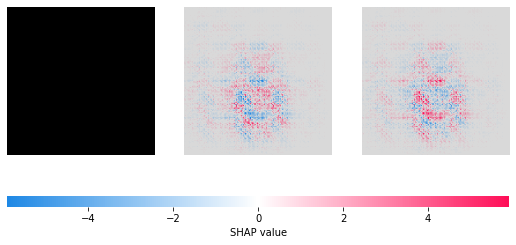

In [338]:
ms1_mns4_fs1k_fns4k_model = resnet.ResNet18(2)
ms1_mns4_fs1k_fns4k_model.load_state_dict(torch.load("../../out/models/PIA_result/SM(ms_1k_mns_4k_fs_1k_fns_4k)_3e.pth", map_location ='cpu'))
ms1_mns4_fs1k_fns4k_model.eval()
ms1_mns4_fs1k_fns4k_explain = shap.DeepExplainer(mns_fs_model, target_baseline)
ms1_mns4_fs1k_fns4k_shap_values = shap_plot(mns_fs_explain, r_img, 49152)

# MS_1K_MNS_4K_FS_1K_FNS_4k

shap_sum 4768.043721374981
shap_sum 4874.783271807207


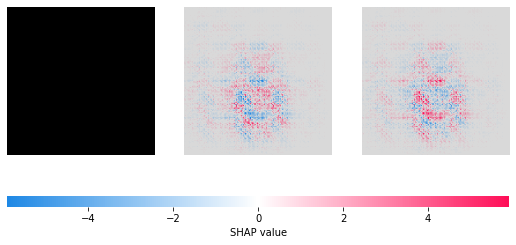

In [339]:
ms4_mns1_fs4_fns1_model = resnet.ResNet18(2)
ms4_mns1_fs4_fns1_model.load_state_dict(torch.load("../../out/models/PIA_result/SM(ms_4k_mns_1k_fs_4k_fns_1k)_3e.pth", map_location ='cpu'))
ms4_mns1_fs4_fns1_model.eval()
ms4_mns1_fs4_fns1_explain = shap.DeepExplainer(mns_fs_model, target_baseline)
ms4_mns1_fs4_fns1_shap_values = shap_plot(mns_fs_explain, r_img, 49152)

# cosine similarity 

In [340]:
ms_fs_female = torch.tensor(ms_fs_shap_values[0]).view(-1) 
ms_fs_male = torch.tensor(ms_fs_shap_values[1]).view(-1)

In [341]:
mns_fns_female = torch.tensor(mns_fns_shap_values[0]).view(-1) 
mns_fns_male = torch.tensor(mns_fns_shap_values[1]).view(-1) 

In [342]:
ms_fns_female = torch.tensor(ms_fns_shap_values[0]).view(-1) 
ms_fns_male = torch.tensor(ms_fns_shap_values[1]).view(-1) 

In [343]:
mns_fs_female = torch.tensor(mns_fs_shap_values[0]).view(-1) 
mns_fs_male = torch.tensor(mns_fs_shap_values[1]).view(-1) 

In [344]:
ms1_mns4_fs1k_fns4k_female=torch.tensor(mns_fns_shap_values[0]).view(-1) 
ms1_mns4_fs1k_fns4k_male= torch.tensor(mns_fns_shap_values[1]).view(-1) 

In [345]:
ms4_mns1_fs4_fns1_female=torch.tensor(mns_fns_shap_values[0]).view(-1) 
ms4_mns1_fs4_fns1_male= torch.tensor(mns_fns_shap_values[1]).view(-1) 

In [346]:
print(sim.cosine_similarity(r_shap_female, ms_fs_female))
print(sim.cosine_similarity(r_shap_female, mns_fns_female))
print(sim.cosine_similarity(r_shap_female, ms_fns_female))
print(sim.cosine_similarity(r_shap_female, mns_fs_female))
print(sim.cosine_similarity(r_shap_female, ms1_mns4_fs1k_fns4k_female))
print(sim.cosine_similarity(r_shap_female, ms4_mns1_fs4_fns1_female))

0.45758533
0.42541337
0.2644672
0.26016942
0.42541337
0.42541337


In [347]:
print(sim.cosine_similarity(r_shap_male, ms_fs_male))
print(sim.cosine_similarity(r_shap_male, mns_fns_male))
print(sim.cosine_similarity(r_shap_male, ms_fns_male))
print(sim.cosine_similarity(r_shap_male, mns_fs_male))
print(sim.cosine_similarity(r_shap_male, ms1_mns4_fs1k_fns4k_male))
print(sim.cosine_similarity(r_shap_male, ms4_mns1_fs4_fns1_male))

0.45494008
0.4257426
0.2666327
0.25962135
0.4257426
0.4257426
